## Main Workbook

This workbook will help guide through the main finalized workflow of my process. Encompassing:

1. Data Loading and Preprocessing
2. Sentiment Analysis
3. Modeling

### Data Loading and Preprocessing

Data is loaded from the Amazon Review Dataset. First step is to import packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Data_Prep_Functions as DP
import Modeling_Functions as MF
import NLP_Functions as NL
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)



Data is loaded in chunks, filtered by comment length, then apppended to a list. To save time, we will just load in the file that we processed earlier.

In [ ]:
review_json_path = 'Books_5.json'

size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      chunksize=size)

total_list = []

def filter_comment_lengths(reviews, minimum, maximum):
    #Filters reviews based on word length, between a minimum and maximum
    #Returns the df with word length as an additional column, and filtered rows of comments between min and max
    reviews['reviewText'] = reviews['reviewText'].astype('str')
    reviews['reviewLen'] = reviews['reviewText'].str.split().map(lambda x: len(x))
    reviews = reviews.loc[(reviews['reviewLen'] > minimum) & (reviews['reviewLen'] < maximum)]
    
    return reviews


for chunk_review in review:

    sample_list = pd.DataFrame(chunk_review[['reviewerID','asin','overall','reviewText']])
    sample_list = filter_comment_lengths(sample_list, 100, 300)
    total_list.append(sample_list)

reviews_total = pd.concat(total_list, ignore_index=True, join='outer', axis=0)


In [2]:
reviews_total = pd.read_csv('reviews_total.csv')

reviews_total.head()

,Unnamed: 0,reviewerID,asin,overall,reviewText,reviewLen
0,0,A1REUF3A1YCPHM,0001713353,5,"The King, the Mice and the Cheese by Nancy Gur...",162
1,1,A3H9YD6K9TVKDP,0001713353,5,Over and over the king has problems. Fortunat...,135
2,2,A1SDAYRVRR62ZH,0001713353,5,"To summarize the story, it's all about trying ...",124
3,3,A2LGACKSC0MALY,0001061240,5,My aunt bought me this book in 1962 - I was te...,143
4,4,AOSS6RJIPV8WS,0001061240,5,I don't know that I can truly explain why I li...,152


In [3]:
def user_book_threshold_reviews(sample_list, user_threshold, book_threshold):
    #Function that takes sample_list and only selects users and books above a threshold. 
    #Returns cleaned dataframe of USER-ID, BOOK-ID, and Scaled RATING for items above the threshold count
    book_count = (sample_list.
         groupby(by = ['asin'])['overall'].
         count().
         reset_index()
        )
    
    
    book_count = book_count.query('overall >= @book_threshold')
    
    user_rating = pd.merge(sample_list, book_count, left_on='asin', right_on='asin', how='inner')
    
    user_count = (sample_list.
         groupby(by = ['reviewerID'])['overall'].
         count().
         reset_index()
        )
    
    user_count = user_count.query('overall >= @user_threshold')
    
    combined = user_rating.merge(user_count, left_on = 'reviewerID', right_on = 'reviewerID', how = 'inner')
    combined_gb = combined.groupby(by = ['reviewerID','asin', 'reviewText'],as_index=False).mean()

    combined_final = combined_gb.drop(columns = ['overall_x','overall'])
    combined_final = combined_final.rename(columns = {'reviewerID':'User-ID', 'asin': 'Book-ID', 'overall_y':'Rating'})
    # scaler = MinMaxScaler()
    # combined_final['Rating'] = combined_final['Rating'].values.astype(float)
    # rating_scaled = pd.DataFrame(scaler.fit_transform(combined_final['Rating'].values.reshape(-1,1)))
    # combined_final['Rating'] = rating_scaled

    return combined_final

reviews_filtered = user_book_threshold_reviews(reviews_total, 100, 100)


### Natural Language Processing

The next step is to use Flair package to analyze the sentiments of each review. 

In [6]:
def flair_sentiment(df):
    #Uses flair package to analyze text sentiment classification. I also add a quantiletranformation to the metric, which is more suitable for learning
    #Returnd DataFrame with raw sentiment score and quantile transformed score, obtained from Flair models
    from flair.models import TextClassifier
    from flair.data import Sentence
    import re
    
    def isfloat(value):
      try:
        float(value)
        return True
      except ValueError:
        return False
    
    sia = TextClassifier.load('en-sentiment')
    def flair_prediction(x):
        sentence = Sentence(x)
        sia.predict(sentence)
        score = str(sentence.labels[0])
        score = score.replace('(',' ').replace(')',' ')
        number = [float(s) for s in score.split() if isfloat(s) is True]
        
        if "POSITIVE" in score:
            return number[0]
        elif "NEGATIVE" in score:
            return -number[0]
        
    df["flair_sentiment"] = df["reviewText"].apply(flair_prediction)

    
    return df


The original dataframe is split into 100 chunks, in order to make this processing more manageable. Since Flair is a neural network based sentiment analysis, this part can take time. It took around 3 hours to complete 144,878 reviews.

In [ ]:

reviews_list = np.array_split(reviews_filtered,100)

flair_list = []
for i in range (0, len(reviews_list)):
    flair_review = flair_sentiment(reviews_list[i])
    flair_list.append(flair_review)
    

reviews_filtered = pd.concat(flair_list)


In [ ]:
reviews_filtered = pd.read_csv('reviews_filtered_100_100.csv')


Since, the Flair sentiment is given as a probability, the variable should be transformed to be more linear. We do this with a quantile transformation.

In [ ]:
def quantile_transform(df):
    
    from sklearn.preprocessing import QuantileTransformer
    reviews_y = df[['flair_sentiment','flair_quantile']]
    
    qt = QuantileTransformer()
    qt2 = QuantileTransformer()
    X_1 = reviews_y.loc[reviews_y['flair_sentiment'] >= 0]
    X_2 = reviews_y.loc[reviews_y['flair_sentiment'] < 0]
    
    X_1['flair_quantile_custom'] = qt.fit_transform(X_1[['flair_sentiment']])/2 + 0.5
    X_2['flair_quantile_custom'] = qt2.fit_transform(X_2[['flair_sentiment']])/2
    
    X = X_1.append(X_2)
    X.sort_index(inplace = True)
    
    return X['flair_quantile_custom']


In [5]:
reviews_filtered['flair_quantile_fixed'] = quantile_transform(reviews_filtered)
reviews_filtered = reviews_filtered.rename(columns = {'flair_quantile_fixed' : 'ReviewRating'})

reviews_filtered.head()

C:\Users\kenhu\Documents\Software\Projects\211013 - Mod4\NLP_Functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1['flair_quantile_custom'] = qt.fit_transform(X_1[['flair_sentiment']])/2 + 0.5
C:\Users\kenhu\Documents\Software\Projects\211013 - Mod4\NLP_Functions.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['flair_quantile_custom'] = qt2.fit_transform(X_2[['flair_sentiment']])/2


,Unnamed: 0,User-ID,Book-ID,reviewText,Unnamed: 0.1,reviewLen,Rating,flair_sentiment,flair_quantile,ReviewRating
0,0,A0762685MUUL2678STKH,006226768X,After Marine brat Harper graduates from high s...,261532.0,125.0,230.0,0.9994,0.621622,0.756507
1,1,A0762685MUUL2678STKH,0988707489,She did it again!!! A beautiful love story bet...,2265496.0,136.0,106.0,0.9995,0.664665,0.781532
2,2,A0762685MUUL2678STKH,0993800130,Wholly Pucked!!! This book will suck you in an...,2334634.0,119.0,277.0,-0.9547,0.175965,0.382549
3,3,A0762685MUUL2678STKH,1471133524,Cami doesn't want to be another notch on a Mad...,2790083.0,123.0,307.0,0.9967,0.443443,0.634134
4,4,A0762685MUUL2678STKH,1471133567,After the fire at the last fight Travis will h...,2790574.0,111.0,130.0,0.9988,0.536537,0.698699


### Modeling

Once the . In this part, I will train 

The first step is to create a pivot table with users and books. The NaN values are filled with 0s.

In [7]:
combined = reviews_filtered.drop_duplicates(['User-ID', 'Book-ID'])
user_book_matrix = combined.pivot(index='User-ID', columns='Book-ID', values='ReviewRating')
user_book_matrix.fillna(0, inplace=True)

user_book_matrix.head(10)

Book-ID,0001048767,0001050230,0001720295,0001844423,0002005549,0002005883,0002051850,0002171856,0002213311,0002226723,...,B017MYOI3Q,B017V4IPPO,B017WJ5PR4,B017WMLTN0,B01BLQES8G,B01CFIEXIY,B01CSGVA8Y,B01FGM4H4Q,B01FKT9TW0,B01FMVUECK
User-ID,,,,,,,,,,,,,,,,,,,,,
A0762685MUUL2678STKH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.698699,0.0
A100U1GGBSDMLL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A100YDQ9DIP06P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A100ZQDV7L8PVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A101BX7DD7EUZ1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A101PAV6G9USQQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A102Z3T7NSM5KC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.876126,0.0,0.0,0.0,0.0,0.000000,0.0
A103M7E0BSFC83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


From the user_book_matrix, we should build SVD embeddings from this. We will use Scipy's svds package to accomplish this. From this, we get 64 length embeddings for each book and and for each user. These embeddings can be thought of as learned features that represent groupings of books in an abstract way.

In [10]:
from scipy.sparse.linalg import svds


def build_SVD_embeddings(user_book_matrix, embedding_length):
    #Builds SVD embeddings to be used later on
    U, Sigma, VT = svds(user_book_matrix, k = embedding_length)
    user_embed_df = pd.DataFrame(U, index = user_book_matrix.index)
    VT_T = np.transpose(VT)
    book_embed_df = pd.DataFrame(VT_T, index = user_book_matrix.columns)
    
    return user_embed_df, book_embed_df


In [11]:
embedding_length = 64
user_embed_df, book_embed_df = build_SVD_embeddings(user_book_matrix, embedding_length)


In [12]:
user_embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
User-ID,,,,,,,,,,,,,,,,,,,,,
A0762685MUUL2678STKH,0.001615,0.006223,0.003623,0.026396,-0.021915,-0.024002,-0.000029,-0.011322,0.002104,-0.001915,...,0.022876,0.031406,-0.018443,0.011510,0.010189,0.001266,-0.003355,0.019283,0.000039,0.012907
A100U1GGBSDMLL,-0.008648,-0.004900,0.023017,-0.006920,-0.006608,0.002867,-0.000593,0.001343,0.006956,-0.021212,...,0.040095,0.030010,-0.042326,0.028061,0.139146,-0.007902,0.004233,-0.023096,-0.001140,0.008999
A100YDQ9DIP06P,-0.000462,-0.000408,-0.000198,0.001602,0.001331,-0.000016,-0.000473,-0.000495,0.000164,-0.000169,...,0.000864,-0.000545,0.000627,-0.000155,0.000118,-0.000181,0.000102,0.000021,0.000474,0.000014
A100ZQDV7L8PVV,0.003530,-0.006180,-0.008830,0.001179,0.004983,-0.003130,0.006481,0.003533,-0.004651,-0.004208,...,0.000584,-0.001151,0.001492,0.000420,0.000870,-0.000111,0.000276,0.000989,0.001841,0.000259
A101BX7DD7EUZ1,-0.008312,0.004125,-0.001180,-0.006227,-0.008739,0.007088,0.004540,-0.007682,0.001419,0.007734,...,0.003296,-0.002244,0.000372,-0.005473,0.000831,-0.000430,0.004195,0.000565,0.003629,0.000159


In [13]:
book_embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Book-ID,,,,,,,,,,,,,,,,,,,,,
0001048767,0.020960,-0.010455,-0.018702,0.016329,-0.019191,0.012008,0.006803,-0.010246,-0.017601,-0.004835,...,-0.014138,0.008198,-0.001163,0.018642,-0.002558,0.001479,-0.034539,-0.008441,0.044524,0.000768
0001050230,0.006238,0.001274,-0.006591,-0.002428,-0.010818,-0.001629,0.005832,-0.005539,-0.003671,0.000746,...,-0.006571,0.003740,-0.005447,-0.001201,-0.000615,0.000190,-0.010192,-0.002149,0.010930,0.000198
0001720295,0.014048,-0.001217,0.013590,0.010285,0.016911,0.019082,-0.007501,-0.011836,0.013056,0.007154,...,0.003108,-0.003941,0.008964,0.007429,0.001270,-0.001664,-0.039235,-0.005453,0.027135,0.000660
0001844423,0.044924,-0.002535,0.005868,0.010604,0.016279,0.000815,0.005137,-0.011827,0.015862,0.007275,...,-0.000437,-0.000470,0.002150,0.001886,0.000266,-0.002322,-0.046291,-0.008263,0.040706,0.000670
0002005549,0.017744,0.012087,-0.000049,-0.006881,-0.012972,0.017529,-0.002652,0.006155,0.003882,0.004617,...,-0.009638,0.005422,0.001365,0.013290,-0.001468,0.003297,-0.000166,-0.002746,0.022836,0.000452


Based on these initial embeddings, we can check how well these book and user embeddings work when we take the dot product to predict the rating.

In [27]:
def SVD_Dot_RSME(user_book_matrix, embedding_length):
    U, Sigma, VT = svds(user_book_matrix, k = embedding_length)
    USigma = np.matmul(U, np.diag(Sigma))
    pred_matrix = np.matmul(USigma, VT)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(np.array(user_book_matrix), pred_matrix)
    return pred_matrix


pred_matrix = SVD_Dot_RSME(user_book_matrix, 64)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

pred_matrix = scaler.fit_transform(pred_matrix)
pred_matrix = pd.DataFrame(pred_matrix, index = user_book_matrix.index, columns = user_book_matrix.columns)

In [28]:
pred_matrix

Book-ID,0001048767,0001050230,0001720295,0001844423,0002005549,0002005883,0002051850,0002171856,0002213311,0002226723,...,B017MYOI3Q,B017V4IPPO,B017WJ5PR4,B017WMLTN0,B01BLQES8G,B01CFIEXIY,B01CSGVA8Y,B01FGM4H4Q,B01FKT9TW0,B01FMVUECK
User-ID,,,,,,,,,,,,,,,,,,,,,
A0762685MUUL2678STKH,0.170266,0.275875,0.216034,0.271985,0.301351,0.118532,0.159149,0.501938,0.202761,0.226842,...,0.238509,0.087350,0.087350,0.170948,0.282845,0.284750,0.336929,0.251490,0.548856,0.116578
A100U1GGBSDMLL,0.165144,0.263612,0.228037,0.267801,0.289965,0.111123,0.153326,0.506539,0.149352,0.241473,...,0.211006,0.092643,0.092643,0.164258,0.272604,0.175699,0.320209,0.253841,0.268596,0.110912
A100YDQ9DIP06P,0.169049,0.270508,0.236226,0.280635,0.297169,0.113257,0.154096,0.497053,0.163532,0.246253,...,0.228460,0.093554,0.093554,0.168510,0.274081,0.249271,0.325387,0.251957,0.307135,0.116459
A100ZQDV7L8PVV,0.175833,0.277700,0.225076,0.273479,0.310407,0.119536,0.160868,0.484215,0.188668,0.238929,...,0.232738,0.081565,0.081565,0.181130,0.273455,0.262914,0.340958,0.249905,0.294998,0.114384
A101BX7DD7EUZ1,0.165135,0.275511,0.230365,0.283657,0.319751,0.126199,0.149344,0.534975,0.176394,0.241330,...,0.214477,0.088535,0.088535,0.153937,0.272236,0.251236,0.377035,0.250555,0.303059,0.116928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZRPAHQG1VHR0,0.188100,0.297303,0.233209,0.291747,0.334530,0.111746,0.145161,0.458787,0.244633,0.316478,...,0.276756,0.045122,0.045122,0.171820,0.303364,0.853532,0.379181,0.244325,0.389938,0.128113
AZTFBJTENKT1T,0.170744,0.270814,0.235198,0.274446,0.316397,0.114667,0.149778,0.503703,0.174786,0.242851,...,0.266281,0.079237,0.079237,0.170743,0.268517,0.247458,0.308514,0.251553,0.306774,0.122883
AZULU4TOTOLEU,0.172706,0.269846,0.235614,0.270697,0.293766,0.115855,0.151741,0.506721,0.181087,0.222282,...,0.210002,0.093907,0.093907,0.158806,0.282151,0.261667,0.294228,0.256953,0.303643,0.101061


In [29]:
def find_pivot_value(x):
    val = pred_matrix.loc[x[0],x[1]]
    return val

predicted_df = combined.copy()
predicted_df['Pred_Rating'] = predicted_df[['User-ID','Book-ID']].apply(find_pivot_value, axis = 1)

predicted_df.head(10)

,Unnamed: 0,User-ID,Book-ID,reviewText,Unnamed: 0.1,reviewLen,Rating,flair_sentiment,flair_quantile,ReviewRating,Pred_Rating
0,0,A0762685MUUL2678STKH,006226768X,After Marine brat Harper graduates from high s...,261532.0,125.0,230.0,0.9994,0.621622,0.756507,0.318712
1,1,A0762685MUUL2678STKH,0988707489,She did it again!!! A beautiful love story bet...,2265496.0,136.0,106.0,0.9995,0.664665,0.781532,0.612724
2,2,A0762685MUUL2678STKH,0993800130,Wholly Pucked!!! This book will suck you in an...,2334634.0,119.0,277.0,-0.9547,0.175965,0.382549,0.243865
3,3,A0762685MUUL2678STKH,1471133524,Cami doesn't want to be another notch on a Mad...,2790083.0,123.0,307.0,0.9967,0.443443,0.634134,0.336396
4,4,A0762685MUUL2678STKH,1471133567,After the fire at the last fight Travis will h...,2790574.0,111.0,130.0,0.9988,0.536537,0.698699,0.381667
5,5,A0762685MUUL2678STKH,147674355X,Sky has the perfect life!! Until she decides s...,2811199.0,102.0,736.0,-0.8235,0.203471,0.437437,0.202992
6,6,A0762685MUUL2678STKH,1477829113,One weekend that's all it takes!! Milo is goin...,2859841.0,104.0,148.0,-0.9907,0.144649,0.326953,0.276745
7,7,A0762685MUUL2678STKH,1490946810,Izzy is married to a very abusive man. Brandon...,2964134.0,148.0,254.0,0.6815,0.248244,0.510776,0.273802
8,8,A0762685MUUL2678STKH,1492375675,WOW!!! Greg Cage is one ALPHA male you do not ...,2983855.0,200.0,151.0,0.9994,0.621622,0.756507,0.314033
9,9,A0762685MUUL2678STKH,1493632639,One night.. that's all it takes to have your l...,3002531.0,113.0,108.0,-0.9995,0.101602,0.233483,0.339160


In [32]:
from sklearn.metrics import mean_squared_error

score = mean_squared_error(predicted_df['ReviewRating'], predicted_df['Pred_Rating'])

score

0.13105844510662273

#### Neural Network

Now, let's train the NN to make the embeddings fit the ReviewRating data much more effectively. First, we need to append them to the Full DataFrame


In [33]:
def append_embeddings(df, user_embed_df, book_embed_df):
    #Append embeddings to the full list of rated user-book combinations
    #Returns df with appended embeddings [user] + [book] in a column
    def find_user_book(x):
        #Functions used to 
        user_row = user_embed_df.loc[user_embed_df.index == x[0]]
        book_row = book_embed_df.loc[book_embed_df.index == x[1]]
        return np.concatenate((np.array(user_row),np.array(book_row)), axis = None)
    
    df['Full-Vector'] = df[['User-ID','Book-ID']].apply(find_user_book, axis = 1)

    return df


In [34]:
reviews_filtered = append_embeddings(reviews_filtered, user_embed_df, book_embed_df)

reviews_filtered.head()

,Unnamed: 0,User-ID,Book-ID,reviewText,Unnamed: 0.1,reviewLen,Rating,flair_sentiment,flair_quantile,ReviewRating,Full-Vector
0,0,A0762685MUUL2678STKH,006226768X,After Marine brat Harper graduates from high s...,261532.0,125.0,230.0,0.9994,0.621622,0.756507,"[0.0016148235157987744, 0.00622327447654668, 0..."
1,1,A0762685MUUL2678STKH,0988707489,She did it again!!! A beautiful love story bet...,2265496.0,136.0,106.0,0.9995,0.664665,0.781532,"[0.0016148235157987744, 0.00622327447654668, 0..."
2,2,A0762685MUUL2678STKH,0993800130,Wholly Pucked!!! This book will suck you in an...,2334634.0,119.0,277.0,-0.9547,0.175965,0.382549,"[0.0016148235157987744, 0.00622327447654668, 0..."
3,3,A0762685MUUL2678STKH,1471133524,Cami doesn't want to be another notch on a Mad...,2790083.0,123.0,307.0,0.9967,0.443443,0.634134,"[0.0016148235157987744, 0.00622327447654668, 0..."
4,4,A0762685MUUL2678STKH,1471133567,After the fire at the last fight Travis will h...,2790574.0,111.0,130.0,0.9988,0.536537,0.698699,"[0.0016148235157987744, 0.00622327447654668, 0..."


Split data into X_train, X_test, y_train, and y_test like you normally would

In [35]:
def create_train_test(df, y_col = 'ReviewRating'):
    #Manipulates the df with Full-Vector to the appropriate format needed for NN modeling.
    #X_train, X_test, y_train, y_test data ready to be fed into NN model
    X_total = df['Full-Vector']

    X_total = np.stack((X_total))
    
    y_total = np.array(df[y_col])
    y_total = np.expand_dims(y_total,axis = 1)
    
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.2 , random_state = 21)

    return X_train, X_test, y_train, y_test


In [36]:
X_train, X_test, y_train, y_test = create_train_test(reviews_filtered)


Try baseline model. There are other models we tried, but the baseline one is the best one

In [40]:
import NN_Model as NN

model_list = []

baseline_model = NN.baseline_model(embedding_length*2)
baseline_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model_list.append(baseline_model)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096

Let's train the model for 35 epochs, using batch size of 128.

In [41]:
trained_mods, results_list = MF.train_multiple_models(model_list, X_train, y_train, 128, 35)


train
Epoch 1/35
787/787 [==============================] - 8s 9ms/step - loss: 0.0725 - mean_absolute_error: 0.2116 - val_loss: 0.0647 - val_mean_absolute_error: 0.2031
Epoch 2/35
787/787 [==============================] - 7s 8ms/step - loss: 0.0640 - mean_absolute_error: 0.1987 - val_loss: 0.0622 - val_mean_absolute_error: 0.1966
Epoch 3/35
787/787 [==============================] - 7s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1958 - val_loss: 0.0614 - val_mean_absolute_error: 0.1917
Epoch 4/35
787/787 [==============================] - 7s 8ms/step - loss: 0.0606 - mean_absolute_error: 0.1932 - val_loss: 0.0602 - val_mean_absolute_error: 0.1944
Epoch 5/35
787/787 [==============================] - 7s 9ms/step - loss: 0.0596 - mean_absolute_error: 0.1915 - val_loss: 0.0598 - val_mean_absolute_error: 0.1888
Epoch 6/35
787/787 [==============================] - 7s 8ms/step - loss: 0.0586 - mean_absolute_error: 0.1897 - val_loss: 0.0590 - val_mean_absolute_error: 0.1886
Epoch 7/35

Now that the model has been trained, we can evaluate the Mean Squared Error of this model on the test set.

In [42]:
mae_list, pred_list = MF.test_multiple_models(trained_mods, X_test, y_test)

mae_list[0]

0.05627718178100003

We can see that this is 0.0563, a large improvement from 0.131 from basic Matrix Factorization. Our NN allows our embeddings to interact more effectively with our target values.

Plotting out or loss, we can see that the training loss keeps decreasing, but the validation loss levels out, so we should terminate the training at this Epoch.

In [44]:
def plot_loss(results):
    #Plot the training loss and the validation loss
    f, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    t = f.suptitle('CNN Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    
    max_epoch = len(results.history['loss'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, results.history['loss'], label='Train MSE')
    ax1.plot(epoch_list, results.history['val_loss'], label='Validation MSE')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('MSE Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('MSE')
    l1 = ax1.legend(loc="best")



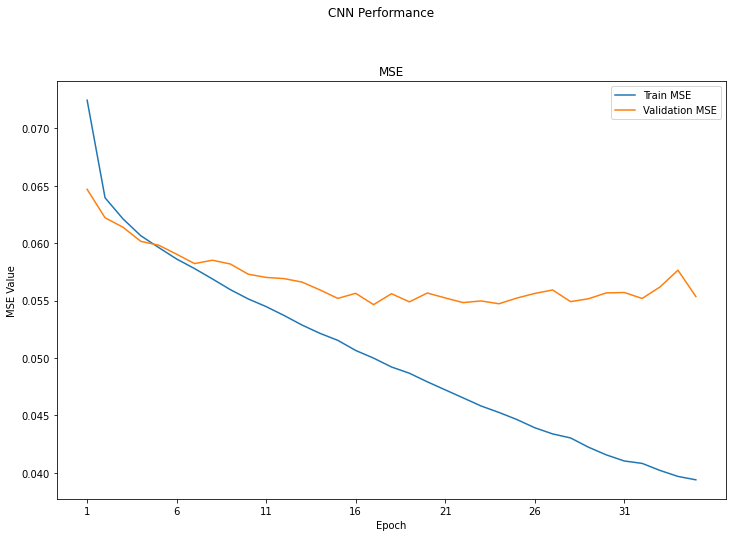

In [45]:
history1 = results_list[0]
plot_loss(history1)



Finally, it's good to test it out on an example. First step is to get the title names of every book in the Dataset. This is done by matching the ASIN with the Metadata, which contains book titles.

In [47]:
def create_book_title_list(df):
    #Starting from a df with a list of Book-IDS, we can create a dataframe that is a directory of the bookIDS with the Actual Title of the Book.
    #Could be useful to add category and author too...Think about this
    meta_json_path = 'meta_Books.json'

    size = 100000
    meta = pd.read_json(meta_json_path, lines=True,
                          chunksize=size)
    
    book_ids = pd.DataFrame(df['Book-ID'].unique())
    book_ids = book_ids.rename(columns = {0: 'Book-ID'})
    
    book_list = []
    for chunk_meta in meta:
        book_merged = book_ids.merge(chunk_meta[['asin','title']], how = 'inner' ,left_on ='Book-ID', right_on = 'asin')
        book_list.append(book_merged)
        
    
    book_merged = pd.concat(book_list, ignore_index=True, join='outer', axis=0)
    book_merged2 = book_merged.groupby(by = ['Book-ID','title'], as_index = False).first()

    return book_merged2
    


book_IDS = create_book_title_list(combined)

book_IDS.head(10)

,Book-ID,title,asin
0,0001048767,Othello: Complete &amp; Unabridged,0001048767
1,0001050230,Love's Labour's Lost: Performed by Derek Jacob...,0001050230
2,0001720295,"Lion, the Witch and the Wardrobe",0001720295
3,0001844423,Magician's Nephew - Folio Society Hardcover,0001844423
4,0002005549,PREY.,0002005549
5,0002005883,Gilead,0002005883
6,0002051850,For Whom the Bell Tolls,0002051850
7,0002171856,The Sas Survival Handbook,0002171856
8,0002213311,Harlequin,0002213311
9,0002226723,North and South,0002226723


Next, we want to get the Top 5 Books (ordered by Sentiment ReviewRating) this user has Read, the Bottom 5 Books, and the Top 5 Recommendations to this user that they have not read. The function below performs this task

In [48]:
def get_top_matches(user_embed_df, book_embed_df, combined_final, book_merged, query_index, model, k_matches = 5):
    #dd
    sampled_user_vector = user_embed_df.iloc[[query_index]]
    sampled_user_ID = sampled_user_vector.index[0]
    
    sampled_user_vector = np.array(user_embed_df.iloc[query_index])
    
    prediction_df = pd.DataFrame(index = book_embed_df.index)
    
    prediction_df.reset_index(inplace = True)
    prediction_df['User-ID'] = sampled_user_ID
    
    def build_prediction_embeddings(x):
        book_row = book_embed_df.loc[book_embed_df.index == x]
        return np.concatenate((sampled_user_vector,np.array(book_row)), axis = None)
    
    
    prediction_df['Full-Vector'] = prediction_df['Book-ID'].apply(build_prediction_embeddings)
    
    X_to_train = np.stack(prediction_df['Full-Vector'])
    
    Y_to_train = model.predict(X_to_train)
    
    prediction_df = prediction_df.merge(book_merged[['Book-ID','title']] , how  = 'outer', on = 'Book-ID')
    prediction_df['Trained_Items'] = Y_to_train
    
    already_read = combined_final[combined_final['User-ID'] == sampled_user_ID]
    
    prediction_df_2 = prediction_df.merge(already_read[['Book-ID','ReviewRating']] , how  = 'left', on = 'Book-ID')
    
    top_5_unrated = prediction_df_2.loc[prediction_df_2['ReviewRating'].isna() == True]
    
    top_5_unrated.sort_values(by = ['Trained_Items'], inplace = True, ascending = False)
    
    top_5_unrated = top_5_unrated.iloc[0:k_matches]
    
    
    rated_books = prediction_df_2.loc[prediction_df_2['ReviewRating'].isna() == False]
    rated_books.sort_values(by = ['ReviewRating'], inplace = True, ascending = False)
    top_5_rated = rated_books.iloc[0:k_matches]

    bottom_5_rated = rated_books.iloc[-k_matches:]
    
    number_of_read_books = rated_books.shape
    return top_5_rated, bottom_5_rated, top_5_unrated, number_of_read_books


In [49]:
query_index = np.random.choice(user_book_matrix.shape[0])

user_id = user_book_matrix.index[query_index]
top_5_rated, bottom_5_rated, top_5_unrated, number_of_read_books = get_top_matches(user_embed_df, book_embed_df, combined, book_IDS, query_index, trained_mods[0], k_matches = 5)


<ipython-input-48-7cdc408e46ac>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_unrated.sort_values(by = ['Trained_Items'], inplace = True, ascending = False)
<ipython-input-48-7cdc408e46ac>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_books.sort_values(by = ['ReviewRating'], inplace = True, ascending = False)


The top 5 Books this user reviewed are listed below. They seem to be into fantasy books

In [50]:
top_5_rated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
1151,0316071048,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Nine Dragons (A Harry Bosch Novel),0.539474,1.000000
1295,0345452704,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Dying to Please,0.688678,0.936687
1813,0452283485,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Bitten (Otherworld),0.643477,0.936687
1173,0316154741,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",The Lincoln Lawyer (Large Print),0.778020,0.936687
1029,0312265867,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",To the Nines: Stephanie Plum Novels,0.532720,0.876126


This user did not like Da Vinci Code or Precious, so perhaps they are quite critical of non fantasy books.

In [52]:
bottom_5_rated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
2893,1477805052,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Wethering the Storm,0.372503,0.514309
1304,034549038X,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",The Dante Club: A Novel,0.541468,0.492594
1377,0349410828,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Apprentice in Death: 43,0.811306,0.350976
514,0099548720,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Precious,0.533744,0.000000
864,0307277674,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",The Da Vinci Code (Robert Langdon),0.240436,0.000000


The top 5 recommendations are listed below. Our algorithm, based on this User's preferences has recommended the following books, which were reviewed positively by users that had similar tastes as this user. The books are mostly fantasy and mystery. So hopefully, this user enjoys these books!

In [53]:
top_5_unrated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
1779,0451235843,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Lover Reborn (Black Dagger Brotherhood),0.876186,NaN
1106,0312935080,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",The Concrete Blonde (Harry Bosch),0.841030,NaN
143,0008123209,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",And Then There Were None: The World's Favourit...,0.836493,NaN
2408,0989450252,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",Crashed (The Driven Trilogy),0.831803,NaN
1479,0385257406,A2BZ7MYTSNYMEW,"[0.002474585232754102, -0.005363539491839383, ...",A Breath Of Snow And Ashes,0.822218,NaN
